# Projet 7 : Réalisez une analyse de sentiments grâce au Deep Learning  

Contexte : Je suis ingénieur IA chez MIC (Marketing Intelligence Consulting), une entreprise de conseil spécialisée sur les problématiques de marketing digital.  
Air Paradis a missionné MIC pour créer un produit IA permettant d’anticiper les bad buzz sur les réseaux sociaux et je suis en charge de développer un prototype fonctionnel d'un modèle de classification.  
Ce notebook concerne l'EDA et la comparaison de plusieurs modèles pour répondre à ce projet.  

# Import des librairies

In [1]:
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import words
from wordcloud import WordCloud
import re
from plot_keras_history import show_history, plot_history
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Input, Bidirectional, Dropout, GRU
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, f1_score
from xgboost import XGBClassifier

# Chargement et exploration des données

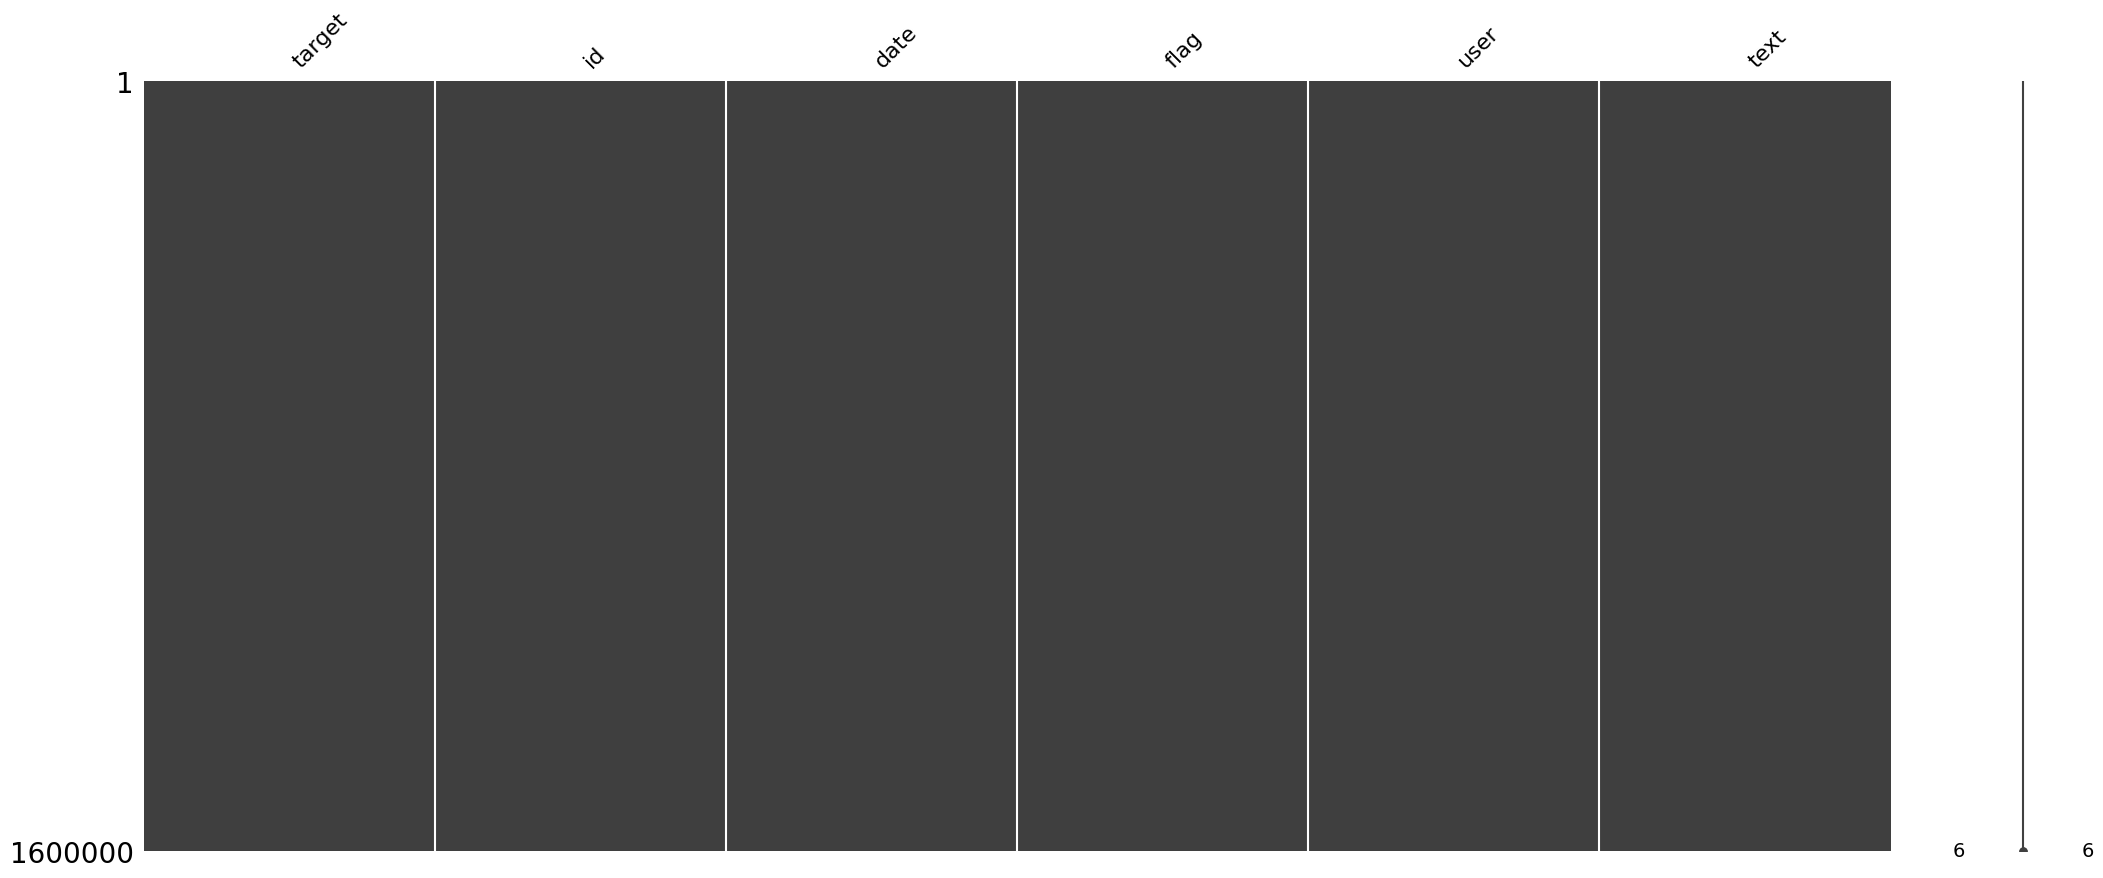

Les dimensions du tableau : 1600000 lignes et 6 colonnes
Nombre de doublons dans le jeu de données : 0
Pourcentage global de valeurs manquantes dans le jeu de données : 0.00%
Nombre de colonnes complètement vides : 0


In [2]:
def charger_donnees():
    chemin_fichier = './data/training.1600000.processed.noemoticon.csv'
    df = pd.read_csv(chemin_fichier, sep=',', encoding='ISO-8859-1', header=None, names=['target', 'id', 'date', 'flag', 'user', 'text'])
    # Visualisation des valeurs manquantes avec msno
    msno.matrix(df)
    plt.show()
    # Afficher les dimensions
    print(f"Les dimensions du tableau : {df.shape[0]} lignes et {df.shape[1]} colonnes")
    # Afficher le nombre de doublons
    num_duplicates = df.duplicated().sum()
    print(f"Nombre de doublons dans le jeu de données : {num_duplicates}")
    # Afficher le pourcentage global de valeurs manquantes
    global_missing_percentage = (df.isnull().mean().mean()) * 100
    print(f'Pourcentage global de valeurs manquantes dans le jeu de données : {global_missing_percentage:.2f}%')
    # Afficher le nombre de colonnes complètement vides
    empty_columns = df.columns[df.isnull().all()]
    num_empty_columns = len(empty_columns)
    print(f"Nombre de colonnes complètement vides : {num_empty_columns}")
    return df
df = charger_donnees()

In [3]:
df.head()

,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [4]:
df.tail()

,target,id,date,flag,user,text
1599995,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599996,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...
1599999,4,2193602129,Tue Jun 16 08:40:50 PDT 2009,NO_QUERY,RyanTrevMorris,happy #charitytuesday @theNSPCC @SparksCharity...


In [5]:
df.sample(10)

,target,id,date,flag,user,text
686221,0,2250981144,Sat Jun 20 02:04:00 PDT 2009,NO_QUERY,TKfan27,Very bored right now.
171391,0,1963200194,Fri May 29 12:21:31 PDT 2009,NO_QUERY,clicktokill,@jerricklim LOL YES! took me awhile to get acc...
1175695,4,1981144175,Sun May 31 08:31:03 PDT 2009,NO_QUERY,x0_kimberlybeth,long night. Recovering then grad parties
534353,0,2197498723,Tue Jun 16 13:51:52 PDT 2009,NO_QUERY,AAmyHaanson,So tired. Got to get hyper before practice but...
655264,0,2239838419,Fri Jun 19 09:01:36 PDT 2009,NO_QUERY,igotnothin,@epsilon723 that sucks
1079010,4,1967982213,Fri May 29 20:33:21 PDT 2009,NO_QUERY,tintinnya,@o2zone hehehe.. That's my daughter thanks.
692301,0,2252459828,Sat Jun 20 06:18:53 PDT 2009,NO_QUERY,yasnakano,@thelonefoodie @chocolatesuze and these are my...
1371521,4,2051185503,Fri Jun 05 21:00:27 PDT 2009,NO_QUERY,SavanaRawrr,Tonight went pretty well. Made some good money...
1126413,4,1975025145,Sat May 30 14:17:24 PDT 2009,NO_QUERY,bbgood_lau,Old times... Watching 'Rojo Fama Contre Fama'...
343855,0,2015548076,Wed Jun 03 04:57:06 PDT 2009,NO_QUERY,RAM544,Going to work in the rain


Par soucis de compréhension, je remplace les target égale à 4 par des tragets égale à 1.  

In [3]:
df["target"] = df["target"].replace(4, 1)

In [7]:
df["target"].value_counts()

target
0    800000
1    800000
Name: count, dtype: int64

La variable target est équilibrée.  

Le nombre moyen de mots par tweet est 13.18


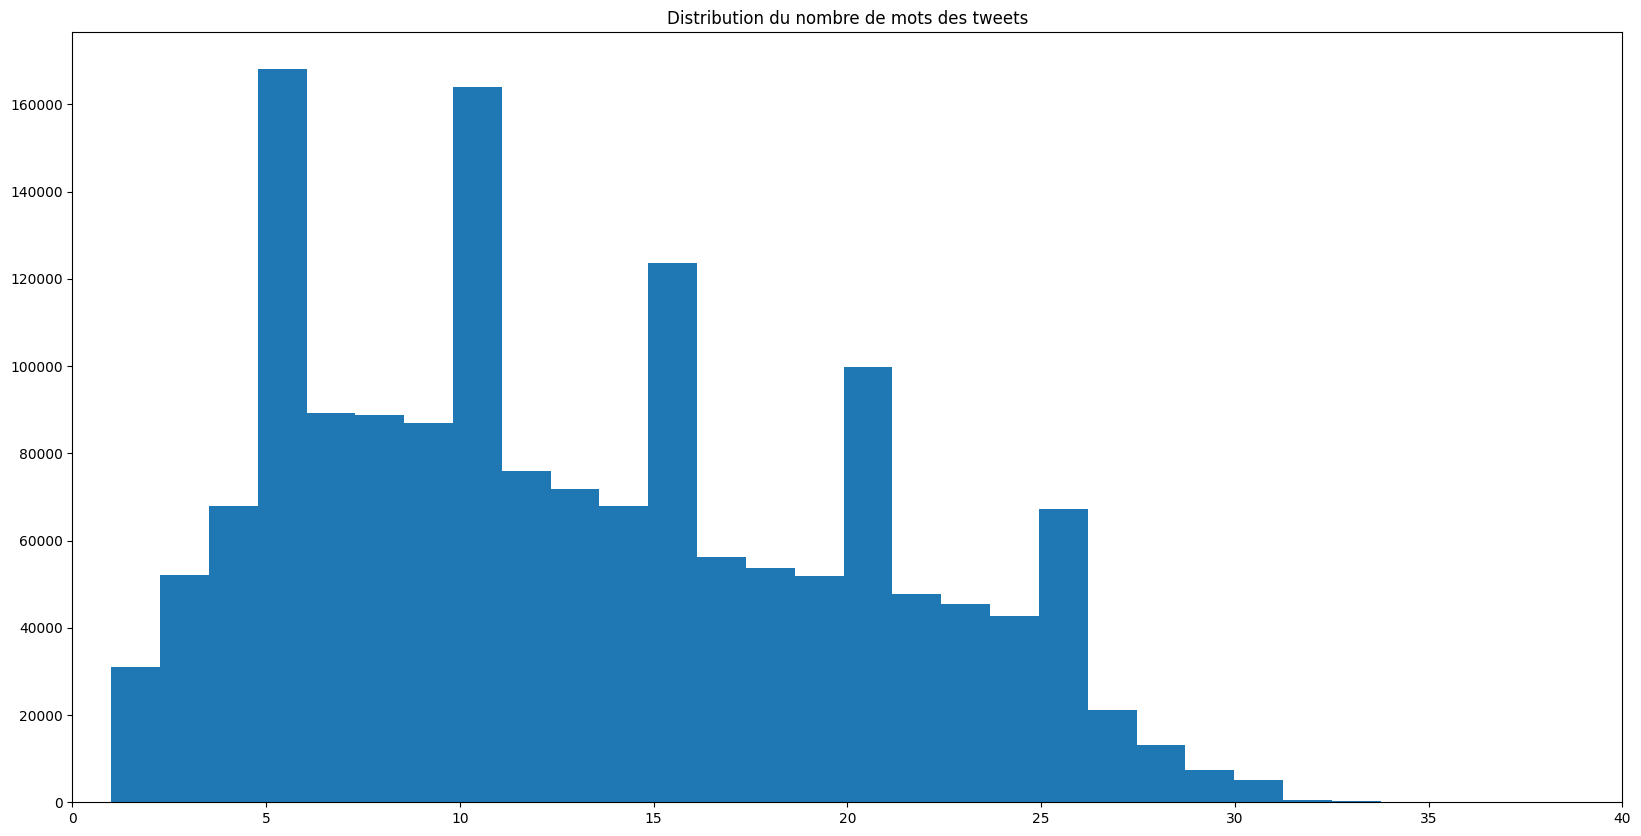

In [8]:
import matplotlib.pyplot as plt

# Calculer le nombre de mots dans chaque tweet
df['word_count'] = df['text'].apply(lambda x: len(x.split()))

# Calculer le nombre moyen de mots
average_word_count = df['word_count'].mean()

print(f"Le nombre moyen de mots par tweet est {average_word_count:.2f}")

# Visualiser la distribution du nombre de mots
plt.figure(figsize=(20,10))
plt.hist(df['word_count'].values, bins=50)
plt.title("Distribution du nombre de mots des tweets")
plt.xlim(0, 40)  # Définir les limites de l'axe des x de 0 à 40
plt.show()


In [9]:
df['word_count'].describe()

count    1.600000e+06
mean     1.317615e+01
std      6.957978e+00
min      1.000000e+00
25%      7.000000e+00
50%      1.200000e+01
75%      1.900000e+01
max      6.400000e+01
Name: word_count, dtype: float64

# Nettoyage des données

In [4]:
def drop_columns(df):
    """
    Supprime toutes les colonnes sauf 'target' et 'text'.
    Args:
        df (pd.DataFrame): DataFrame contenant les données des tweets.
    Return:
        pd.DataFrame: DataFrame modifié.
    """
    df = df[['target', 'text']]
    return df

def drop_text_duplicate(df):
    """
    Supprime les tweets en double.
    Args:
        df (pd.DataFrame): DataFrame contenant les données des tweets.
    Return:
        pd.DataFrame: DataFrame sans doublons.
    """
    initial_len = len(df)
    df = df.drop_duplicates(subset="text")
    final_len = len(df)
    print(f"Nombre de tweets en double supprimés : {initial_len - final_len}")
    return df

def filter_tweet(df):
    """
    Filtre et supprime les tweets non informatifs et affiche les premières lignes supprimées.
    Args:
        df (pd.DataFrame): DataFrame contenant les données des tweets.
    Return:
        pd.DataFrame: DataFrame filtré.
    """
    initial_len = len(df)
    df['text'] = df['text'].str.strip()
    filtered_df = df[df['text'].str.match('^(@\w+\s*)+$')]
    df = df.drop(filtered_df.index, axis= 0)
    final_len = len(df)
    display(filtered_df.head(20))
    print(f"Nombre de tweets non informatif supprimés : {initial_len - final_len}")
    return df

def drop_single_token_tweets(df):
    """
    Supprime les tweets avec un seul token.
    Args:
        df (pd.DataFrame): DataFrame contenant les données des tweets.
    Return:
        pd.DataFrame: DataFrame modifié.
    """
    initial_len = len(df)
    df['tokens'] = df['text'].str.split()
    df = df[df['tokens'].str.len() > 1]
    final_len = len(df)
    print(f"Nombre de tweets avec un seul token supprimés : {initial_len - final_len}")
    return df

def remove_at_mentions(df):
    """
    Supprime les mots qui commencent par @.
    Args:
        df (pd.DataFrame): DataFrame contenant les données des tweets.
    Return:
        pd.DataFrame: DataFrame modifié.
    """
    df['text'] = df['text'].apply(lambda x: ' '.join(re.sub(r"(@[A-Za-z0-9]+)","",x).split()))
    return df

def remove_urls(df):
    """
    Supprime les adresses de site internet.
    Args:
        df (pd.DataFrame): DataFrame contenant les données des tweets.
    Return:
        pd.DataFrame: DataFrame modifié.
    """
    df['text'] = df['text'].apply(lambda x: re.sub(r"http\S+|www.\S+", "", x))
    return df


# On applique les fonctions de nettoyages du jeu de données
df = drop_columns(df)
df = drop_text_duplicate(df)
df = filter_tweet(df)
df = drop_single_token_tweets(df)
df = remove_at_mentions(df)
df = remove_urls(df)
df = df.reset_index(drop=True)

Nombre de tweets en double supprimés : 18534


,target,text
208,0,@mandayyy
249,0,@mandayyy
398,0,@danadearmond
430,0,@anistorm
1011,0,@citizensheep
1014,0,@GirlsGoneChild
1231,0,@thecoolestout
1421,0,@marlonjenglish
1486,0,@oishiieats
1641,0,@thisisguan


Nombre de tweets non informatif supprimés : 2552
Nombre de tweets avec un seul token supprimés : 2036


In [11]:
df.shape

(1576878, 3)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1576878 entries, 0 to 1576877
Data columns (total 3 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1576878 non-null  int64 
 1   text    1576878 non-null  object
 2   tokens  1576878 non-null  object
dtypes: int64(1), object(2)
memory usage: 36.1+ MB


In [13]:
df.head()

,target,text,tokens
0,0,"- Awww, that's a bummer. You shoulda got Davi...","[@switchfoot, http://twitpic.com/2y1zl, -, Aww..."
1,0,is upset that he can't update his Facebook by ...,"[is, upset, that, he, can't, update, his, Face..."
2,0,I dived many times for the ball. Managed to sa...,"[@Kenichan, I, dived, many, times, for, the, b..."
3,0,my whole body feels itchy and like its on fire,"[my, whole, body, feels, itchy, and, like, its..."
4,0,"no, it's not behaving at all. i'm mad. why am ...","[@nationwideclass, no,, it's, not, behaving, a..."


In [5]:
def expand_contractions(text: str) -> str:
    """
    Étend les contractions dans une chaîne de texte.
    Args:
        text (str): Texte d'entrée. 
    Return:
        str: Texte avec contractions étendues.
    """
    flags = re.IGNORECASE | re.MULTILINE
    
    text = re.sub(r'`', "'", text, flags = flags)
    
    ## starts / ends with '
    text = re.sub(
        r"(\s|^)'(aight|cause)(\s|$)",
        '\g<1>\g<2>\g<3>',
        text, flags = flags
    )
    
    text = re.sub(
        r"(\s|^)'t(was|is)(\s|$)", r'\g<1>it \g<2>\g<3>',
        text,
        flags = flags
    )
    
    text = re.sub(
        r"(\s|^)ol'(\s|$)",
        '\g<1>old\g<2>',
        text, flags = flags
    )
    
    ## expand words without '
    text = re.sub(r"\b(aight)\b", 'alright', text, flags = flags)
    text = re.sub(r'\bcause\b', 'because', text, flags = flags)
    text = re.sub(r'\b(finna|gonna)\b', 'going to', text, flags = flags)
    text = re.sub(r'\bgimme\b', 'give me', text, flags = flags)
    text = re.sub(r"\bgive'n\b", 'given', text, flags = flags)
    text = re.sub(r"\bhowdy\b", 'how do you do', text, flags = flags)
    text = re.sub(r"\bgotta\b", 'got to', text, flags = flags)
    text = re.sub(r"\binnit\b", 'is it not', text, flags = flags)
    text = re.sub(r"\b(can)(not)\b", r'\g<1> \g<2>', text, flags = flags)
    text = re.sub(r"\bwanna\b", 'want to', text, flags = flags)
    text = re.sub(r"\bmethinks\b", 'me thinks', text, flags = flags)
    
    ## one offs,
    text = re.sub(r"\bo'er\b", r'over', text, flags = flags)
    text = re.sub(r"\bne'er\b", r'never', text, flags = flags)
    text = re.sub(r"\bo'?clock\b", 'of the clock', text, flags = flags)
    text = re.sub(r"\bma'am\b", 'madam', text, flags = flags)
    text = re.sub(r"\bgiv'n\b", 'given', text, flags = flags)
    text = re.sub(r"\be'er\b", 'ever', text, flags = flags)
    text = re.sub(r"\bd'ye\b", 'do you', text, flags = flags)
    text = re.sub(r"\be'er\b", 'ever', text, flags = flags)
    text = re.sub(r"\bd'ye\b", 'do you', text, flags = flags)
    text = re.sub(r"\bg'?day\b", 'good day', text, flags = flags)
    text = re.sub(r"\b(ain|amn)'?t\b", 'am not', text, flags = flags)
    text = re.sub(r"\b(are|can)'?t\b", r'\g<1> not', text, flags = flags)
    text = re.sub(r"\b(let)'?s\b", r'\g<1> us', text, flags = flags)
    
    ## major expansions involving smaller,
    text = re.sub(r"\by'all'dn't've'd\b", 'you all would not have had', text, flags = flags)
    text = re.sub(r"\by'all're\b", 'you all are', text, flags = flags)
    text = re.sub(r"\by'all'd've\b", 'you all would have', text, flags = flags)
    text = re.sub(r"(\s)y'all(\s)", r'\g<1>you all\g<2>', text, flags = flags)
    
    ## minor,
    text = re.sub(r"\b(won)'?t\b", 'will not', text, flags = flags)
    text = re.sub(r"\bhe'd\b", 'he had', text, flags = flags)

    ## major,
    text = re.sub(r"\b(I|we|who)'?d'?ve\b", r'\g<1> would have', text, flags = flags)
    text = re.sub(r"\b(could|would|must|should|would)n'?t'?ve\b", r'\g<1> not have', text, flags = flags)
    text = re.sub(r"\b(he)'?dn'?t'?ve'?d\b", r'\g<1> would not have had', text, flags = flags)
    text = re.sub(r"\b(daren|daresn|dasn)'?t", 'dare not', text, flags = flags)
    text = re.sub(r"\b(he|how|i|it|she|that|there|these|they|we|what|where|which|who|you)'?ll\b", r'\g<1> will', text, flags = flags)
    text = re.sub(r"\b(everybody|everyone|he|how|it|she|somebody|someone|something|that|there|this|what|when|where|which|who|why)'?s\b", r'\g<1> is', text, flags = flags)
    text = re.sub(r"\b(I)'?m'a\b", r'\g<1> am about to', text, flags = flags)
    text = re.sub(r"\b(I)'?m'o\b", r'\g<1> am going to', text, flags = flags)
    text = re.sub(r"\b(I)'?m\b", r'\g<1> am', text, flags = flags)
    text = re.sub(r"\bshan't\b", 'shall not', text, flags = flags)
    text = re.sub(r"\b(are|could|did|does|do|go|had|has|have|is|may|might|must|need|ought|shall|should|was|were|would)n'?t\b", r'\g<1> not', text, flags = flags)
    text = re.sub(r"\b(could|had|he|i|may|might|must|should|these|they|those|to|we|what|where|which|who|would|you)'?ve\b", r'\g<1> have', text, flags = flags)
    text = re.sub(r"\b(how|so|that|there|these|they|those|we|what|where|which|who|why|you)'?re\b", r'\g<1> are', text, flags = flags)
    text = re.sub(r"\b(I|it|she|that|there|they|we|which|you)'?d\b", r'\g<1> had', text, flags = flags)
    text = re.sub(r"\b(how|what|where|who|why)'?d\b", r'\g<1> did', text, flags = flags)
    
    return text

In [6]:
df['text'] = df['text'].apply(expand_contractions)

# Prétraitement Texte

In [7]:
# Télchargement des listes nécessaire au prétraitement
nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('words')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\pierr\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\pierr\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pierr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\pierr\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [17]:
def display_tokens_info(tokens):
    print(f"nb tokens {len(tokens)}, nb tokens uniques {len(set(tokens))}")
    print(tokens[:30])

In [8]:
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer, PorterStemmer

def process_text(doc,
                rejoin=False,
                lemm_or_stemm=0,
                list_rare_words=None,
                min_len_word=0,
                force_is_alpha=True,
                eng_words=None,
                remove_words=None,
                include_stopwords=True,
                lowercase=True):

    # list_unique_words
    if not list_rare_words:
        list_rare_words = []

    # lower
    if lowercase:
        doc = doc.lower().strip()
    else:
        doc = doc.strip()

    # tokenize
    tokenizer = RegexpTokenizer(r"\w+")
    raw_tokens_list = tokenizer.tokenize(doc)

    # stop words
    stop_words = set(stopwords.words('english'))
    cleaned_tokens_list = [w for w in raw_tokens_list if w not in stop_words]

    # include stopwords if specified
    if include_stopwords:
        cleaned_tokens_list += [w for w in raw_tokens_list if w in stop_words]

    # no rare tokens
    non_rare_tokens = [w for w in cleaned_tokens_list if w not in list_rare_words]

    # remove additional words
    if remove_words:
        non_rare_tokens = [w for w in non_rare_tokens if w not in remove_words]

    # no more len words
    more_than_N = [w for w in non_rare_tokens if len(w) >= min_len_word]

    # only alpha chars
    if force_is_alpha:
        alpha_tokens = [w for w in more_than_N if w.isalpha()]
    else:
        alpha_tokens = more_than_N

    # Stem or lem
    if lemm_or_stemm == "lem":
        trans = WordNetLemmatizer()
        trans_text = [trans.lemmatize(i) for i in alpha_tokens]
    elif lemm_or_stemm == "stem":
        trans = PorterStemmer()
        trans_text = [trans.stem(i) for i in alpha_tokens]
    else:
        trans_text = alpha_tokens.copy()

    # in english
    if eng_words:
        engl_text = [i for i in trans_text if i in eng_words]
    else:
        engl_text = trans_text

    # manage return type
    if rejoin:
        return " ".join(engl_text)

    return engl_text

In [19]:
raw_corpus = " ".join(df.text.values)
raw_corpus[:1000]

" - Awww, that is a bummer. You shoulda got David Carr of Third Day to do it. ;D is upset that he can not update his Facebook by texting it... and might cry as a result School today also. Blah! I dived many times for the ball. Managed to save 50% The rest go out of bounds my whole body feels itchy and like it is on fire no, it is not behaving at all. i am mad. why am i here? because I can not see you all over there. not the whole crew Need a hug hey long time no see! Yes.. Rains a bit ,only a bit LOL , I am fine thanks , how is you ? _K nope they did not have it que me muera ? spring break in plain city... it is snowing I just re-pierced my ears I could not bear to watch it. And I thought the UA loss was embarrassing . . . . . It it counts, idk why I did either. you never talk to me anymore i would have been the first, but i did not have a gun. not really though, zac snyder's just a doucheclown. I wish I got to watch it with you!! I miss you and how was the premiere?! Hollis' death sce

In [20]:
len(raw_corpus)

107975841

In [21]:
tokenizer = RegexpTokenizer(r"\w+")
raw_tokens_list = tokenizer.tokenize(raw_corpus)

In [22]:
tmp = pd.Series(raw_tokens_list).value_counts()
tmp.head()

I      664546
to     603748
the    488810
is     413869
a      371341
Name: count, dtype: int64

In [23]:
display_tokens_info(raw_tokens_list)

nb tokens 21273058, nb tokens uniques 396652
['Awww', 'that', 'is', 'a', 'bummer', 'You', 'shoulda', 'got', 'David', 'Carr', 'of', 'Third', 'Day', 'to', 'do', 'it', 'D', 'is', 'upset', 'that', 'he', 'can', 'not', 'update', 'his', 'Facebook', 'by', 'texting', 'it', 'and']


In [24]:
tmp.describe()

count    396652.000000
mean         53.631541
std        2553.921367
min           1.000000
25%           1.000000
50%           1.000000
75%           3.000000
max      664546.000000
Name: count, dtype: float64

In [25]:
corpus = process_text(raw_corpus,
                      rejoin=False,
                      lemm_or_stemm = "lem")
display_tokens_info(corpus)

nb tokens 20869217, nb tokens uniques 252552
['awww', 'bummer', 'shoulda', 'got', 'david', 'carr', 'third', 'day', 'upset', 'update', 'facebook', 'texting', 'might', 'cry', 'result', 'school', 'today', 'also', 'blah', 'dived', 'many', 'time', 'ball', 'managed', 'save', 'rest', 'go', 'bound', 'whole', 'body']


In [26]:
tmp = pd.Series(corpus).value_counts()
tmp.head()

i      1011913
to      611224
the     521444
is      427909
a       424965
Name: count, dtype: int64

In [27]:
# Les tokens les moins présents
tmp.tail()

bodyyy           1
whatevercrap     1
ballsack         1
hairbrushless    1
hadn             1
Name: count, dtype: int64

In [28]:
tmp.describe()

count    2.525520e+05
mean     8.263335e+01
std      3.643453e+03
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      3.000000e+00
max      1.011913e+06
Name: count, dtype: float64

In [29]:
tmp = pd.Series(corpus).value_counts()
list_unique_words = tmp[tmp==1]
list_unique_words = list(list_unique_words.index)
tmp = pd.DataFrame({"words" : list_unique_words})
tmp.to_csv("C:/Users/pierr/Projet7/list_unique_words.csv", index=False)

In [30]:
tmp = pd.Series(corpus).value_counts()
list_min_5_words = tmp[tmp<=5]
list_min_5_words = list(list_min_5_words.index)
tmp = pd.DataFrame({"words" : list_min_5_words})
tmp.to_csv("C:/Users/pierr/Projet7/list_min_5_words.csv", index=False)

In [31]:
df_positifs = df[df['target'] == 0].sample(n=10000, random_state=0)
df_negatifs = df[df['target'] == 1].sample(n=10000, random_state=0)

# Concaténer les deux dataframes
df_model = pd.concat([df_positifs, df_negatifs])

# Mélanger les données
df_model = df_model.sample(frac=1, random_state=1).reset_index(drop=True)

In [32]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   target  20000 non-null  int64 
 1   text    20000 non-null  object
 2   tokens  20000 non-null  object
dtypes: int64(1), object(2)
memory usage: 468.9+ KB


J'ai ici effectué plusieurs tests de prétraitements à partir de la fonction "process_text".  
Vous ne trouverez ici que les meilleurs prétraitements que j'ai pu trouvé en fonction de la normalisation appliquée à la variable "text".  

In [33]:
df_model['text_filter_lem'] = df_model['text'].apply(lambda x : process_text(x,
                                                             rejoin=True,
                                                            lemm_or_stemm="lem",
                                                            force_is_alpha=True,
                                                            include_stopwords=True))

df_model['text_filter_stem'] = df_model['text'].apply(lambda x : process_text(x,
                                                             rejoin=True,
                                                            lemm_or_stemm="stem",
                                                            force_is_alpha=True,
                                                            include_stopwords=True))

df_model['text_filter'] = df_model['text'].apply(lambda x : process_text(x,
                                                             rejoin=True,
                                                            lemm_or_stemm=0,
                                                            force_is_alpha=True,
                                                            include_stopwords=True))

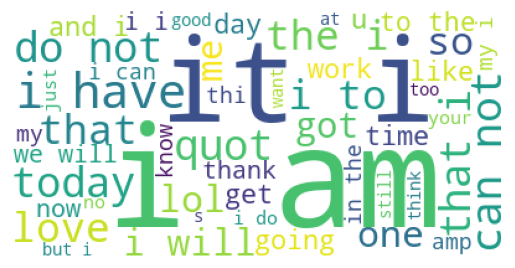

In [34]:
wordcloud = WordCloud (background_color = 'white',
                       stopwords=[],
                       max_words=50).generate(" ".join(df_model['text_filter_lem']))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

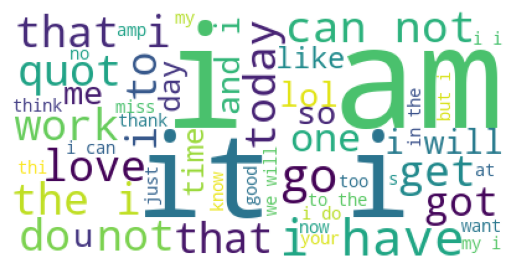

In [35]:
wordcloud = WordCloud (background_color = 'white',
                       stopwords=[],
                       max_words=50).generate(" ".join(df_model['text_filter_stem']))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

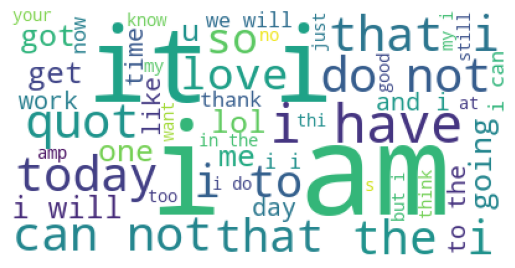

In [36]:
wordcloud = WordCloud (background_color = 'white',
                       stopwords=[],
                       max_words=50).generate(" ".join(df_model['text_filter']))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [37]:
df_model.head()

,target,text,tokens,text_filter_lem,text_filter_stem,text_filter
0,1,My paintings are now available as prints onlin...,"[@tompauley, My, paintings, are, now, availabl...",painting available print online my are now a at,paint avail print onlin my are now as at,paintings available prints online my are now a...
1,1,#myweakness MEXICAN FOOD!!,"[#myweakness, MEXICAN, FOOD!!]",myweakness mexican food,myweak mexican food,myweakness mexican food
2,0,"nah i am not i am afraid, i can not get the da...","[@beckym1985, nah, im, not, im, afraid,, i, ca...",nah afraid get day work seeing sherwood tho i ...,nah afraid get day work see sherwood tho i am ...,nah afraid get day work seeing sherwoods tho i...
3,1,_stam told you i would tweet you. The least i ...,"[@e_stam, told, you, i, would, tweet, you., Th...",told would tweet least could got addicted p il...,told would tweet least could got addict p ili ...,told would tweet least could got addicted p il...
4,0,Glad to see O sending ppl your way...sad that ...,"[@ogzonedotorg, Glad, to, see, O, sending, ppl...",glad see sending ppl way sad told go look quot...,glad see send ppl way sad told go look quot ad...,glad see sending ppl way sad told go look quot...


In [38]:
df_model.sample(10)

,target,text,tokens,text_filter_lem,text_filter_stem,text_filter
14456,1,thought her audition went we will,"[thought, her, audition, went, well]",thought audition went her we will,thought audit went her we will,thought audition went her we will
16659,1,"First day of school tomorrow, after 2.5 years....","[First, day, of, school, tomorrow,, after, 2.5...",first day school tomorrow year halo head of af...,first day school tomorrow year halo head of af...,first day school tomorrow years halo head of a...
12570,1,exams are finished!!! Home on thursday,"[exams, are, finished!!!, Home, on, thursday]",exam finished home thursday are on,exam finish home thursday are on,exams finished home thursday are on
7475,0,I just thought I was going to have light in my...,"[I, just, thought, I, was, going, to, have, li...",thought going light room tonight guessed wrong...,thought go light room tonight guess wrong i ju...,thought going light room tonight guessed wrong...
7138,1,"Ohhh, so smart! Thanks for sharing your genius...","[@aranarose, Ohhh,, so, smart!, Thanks, for, s...",ohhh smart thanks sharing genius already insta...,ohhh smart thank share geniu alreadi instal sl...,ohhh smart thanks sharing genius already insta...
19140,1,That is awesome! You can not hate the cheesy s...,"[@TozaBoma, That, is, awesome!, You, can't, ha...",awesome hate cheesy show love that is you can ...,awesom hate cheesi show love that is you can n...,awesome hate cheesy shows love that is you can...
8902,1,I love seeing the true side of some people ......,"[I, love, seeing, the, true, side, of, some, p...",love seeing true side people smile nod save da...,love see true side peopl smile nod save day i ...,love seeing true side people smile nod save da...
14102,1,YAY MIMI!!! Pulled that one out of your backsi...,"[@SiriousB1, YAY, MIMI!!!, Pulled, that, one, ...",yay mimi pulled one backside that out of your,yay mimi pull one backsid that out of your,yay mimi pulled one backside that out of your
8071,0,Stress is shadowing my excitement :/,"[Stress, is, shadowing, my, excitement, :/]",stress shadowing excitement is my,stress shadow excit is my,stress shadowing excitement is my
19594,1,Happy Monday everyone.,"[Happy, Monday, everyone.]",happy monday everyone,happi monday everyon,happy monday everyone


In [39]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   target            20000 non-null  int64 
 1   text              20000 non-null  object
 2   tokens            20000 non-null  object
 3   text_filter_lem   20000 non-null  object
 4   text_filter_stem  20000 non-null  object
 5   text_filter       20000 non-null  object
dtypes: int64(1), object(5)
memory usage: 937.6+ KB


# Comparaison pré traitement et normalisation

## Meilleur prétraitement sans normalisation

In [40]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# Séparation des données en ensembles d'entraînement, de test et de validation
X_train, X_temp, y_train, y_temp = train_test_split(df_model['text_filter'], df_model['target'], test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Vectorisation des tweets
vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_val_vec = vectorizer.transform(X_val)
X_test_vec = vectorizer.transform(X_test)

# Entraînement du modèle
model = LogisticRegression()
model.fit(X_train_vec, y_train)

# Prédiction et évaluation du modèle sur l'ensemble de validation
y_val_pred = model.predict(X_val_vec)
accuracy_val = accuracy_score(y_val, y_val_pred)
recall_val = recall_score(y_val, y_val_pred, average='weighted')
f1_val = f1_score(y_val, y_val_pred, average='weighted')
auc_val = roc_auc_score(y_val, y_val_pred)
tn, fp, fn, tp = confusion_matrix(y_val, y_val_pred).ravel()
specificity_val = tn / (tn+fp)

print(f'Validation Accuracy: {accuracy_val}')
print(f'Validation Recall: {recall_val}')
print(f'Validation F1 Score: {f1_val}')
print(f'Validation AUC: {auc_val}')
print(f'Validation Specificity: {specificity_val}')

# Prédiction et évaluation du modèle sur l'ensemble de test
y_test_pred = model.predict(X_test_vec)
accuracy_test = accuracy_score(y_test, y_test_pred)
recall_test = recall_score(y_test, y_test_pred, average='weighted')
f1_test = f1_score(y_test, y_test_pred, average='weighted')
auc_test = roc_auc_score(y_test, y_test_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()
specificity_test = tn / (tn+fp)

print(f'Test Accuracy: {accuracy_test}')
print(f'Test Recall: {recall_test}')
print(f'Test F1 Score: {f1_test}')
print(f'Test AUC: {auc_test}')
print(f'Test Specificity: {specificity_test}')



Validation Accuracy: 0.7775
Validation Recall: 0.7775
Validation F1 Score: 0.7775741824158218
Validation AUC: 0.7777692661253256
Validation Specificity: 0.7704918032786885
Test Accuracy: 0.748
Test Recall: 0.748
Test F1 Score: 0.7479091982784506
Test AUC: 0.747702255530792
Test Specificity: 0.7311608961303462


## Meilleur prétraitement stemmer

In [41]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, f1_score

# Séparation des données en ensembles d'entraînement, de test et de validation
X_train, X_temp, y_train, y_temp = train_test_split(df_model['text_filter_stem'], df_model['target'], test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Vectorisation des tweets
vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_val_vec = vectorizer.transform(X_val)
X_test_vec = vectorizer.transform(X_test)

# Entraînement du modèle
model = LogisticRegression()
model.fit(X_train_vec, y_train)

# Prédiction et évaluation du modèle sur l'ensemble de validation
y_val_pred = model.predict(X_val_vec)
accuracy_val = accuracy_score(y_val, y_val_pred)
recall_val = recall_score(y_val, y_val_pred, average='weighted')
f1_val = f1_score(y_val, y_val_pred, average='weighted')
auc_val = roc_auc_score(y_val, y_val_pred)
tn, fp, fn, tp = confusion_matrix(y_val, y_val_pred).ravel()
specificity_val = tn / (tn+fp)

print(f'Validation Accuracy: {accuracy_val}')
print(f'Validation Recall: {recall_val}')
print(f'Validation F1 Score: {f1_val}')
print(f'Validation AUC: {auc_val}')
print(f'Validation Specificity: {specificity_val}')

# Prédiction et évaluation du modèle sur l'ensemble de test
y_test_pred = model.predict(X_test_vec)
accuracy_test = accuracy_score(y_test, y_test_pred)
recall_test = recall_score(y_test, y_test_pred, average='weighted')
f1_test = f1_score(y_test, y_test_pred, average='weighted')
auc_test = roc_auc_score(y_test, y_test_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()
specificity_test = tn / (tn+fp)

print(f'Test Accuracy: {accuracy_test}')
print(f'Test Recall: {recall_test}')
print(f'Test F1 Score: {f1_test}')
print(f'Test AUC: {auc_test}')
print(f'Test Specificity: {specificity_test}')

Validation Accuracy: 0.775
Validation Recall: 0.775
Validation F1 Score: 0.7750675422138837
Validation AUC: 0.7751361614049633
Validation Specificity: 0.7714561234329798
Test Accuracy: 0.7515
Test Recall: 0.7515
Test F1 Score: 0.751345424571316
Test AUC: 0.7511043578119311
Test Specificity: 0.7291242362525459


## Meilleur prétraitement Lemmatizer

In [42]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, f1_score

# Séparation des données en ensembles d'entraînement, de test et de validation
X_train, X_temp, y_train, y_temp = train_test_split(df_model['text_filter_lem'], df_model['target'], test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Vectorisation des tweets
vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_val_vec = vectorizer.transform(X_val)
X_test_vec = vectorizer.transform(X_test)

# Entraînement du modèle
model = LogisticRegression()
model.fit(X_train_vec, y_train)

# Prédiction et évaluation du modèle sur l'ensemble de validation
y_val_pred = model.predict(X_val_vec)
accuracy_val = accuracy_score(y_val, y_val_pred)
recall_val = recall_score(y_val, y_val_pred, average='weighted')
f1_val = f1_score(y_val, y_val_pred, average='weighted')
auc_val = roc_auc_score(y_val, y_val_pred)
tn, fp, fn, tp = confusion_matrix(y_val, y_val_pred).ravel()
specificity_val = tn / (tn+fp)

print(f'Validation Accuracy: {accuracy_val}')
print(f'Validation Recall: {recall_val}')
print(f'Validation F1 Score: {f1_val}')
print(f'Validation AUC: {auc_val}')
print(f'Validation Specificity: {specificity_val}')

# Prédiction et évaluation du modèle sur l'ensemble de test
y_test_pred = model.predict(X_test_vec)
accuracy_test = accuracy_score(y_test, y_test_pred)
recall_test = recall_score(y_test, y_test_pred, average='weighted')
f1_test = f1_score(y_test, y_test_pred, average='weighted')
auc_test = roc_auc_score(y_test, y_test_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()
specificity_test = tn / (tn+fp)

print(f'Test Accuracy: {accuracy_test}')
print(f'Test Recall: {recall_test}')
print(f'Test F1 Score: {f1_test}')
print(f'Test AUC: {auc_test}')
print(f'Test Specificity: {specificity_test}')

Validation Accuracy: 0.7705
Validation Recall: 0.7705
Validation F1 Score: 0.7705776495150806
Validation AUC: 0.7709449236004091
Validation Specificity: 0.7589199614271939
Test Accuracy: 0.746
Test Recall: 0.746
Test F1 Score: 0.7459382329718366
Test AUC: 0.7457556248224425
Test Specificity: 0.7321792260692465


# Modèle simple

In [43]:
def train_evaluate_simple_model(run_name, model, X_train_vec, y_train, X_val_vec, y_val):
    import mlflow
    import mlflow.sklearn
    from sklearn.metrics import accuracy_score, recall_score, f1_score, roc_auc_score, confusion_matrix

    model_name = type(model).__name__

    # Initialisation d'un run avec le nom donné
    with mlflow.start_run(run_name=run_name):
        # Entraînement du modèle
        model.fit(X_train_vec, y_train)

        # Prédiction et évaluation du modèle sur l'ensemble de validation
        y_val_pred = model.predict(X_val_vec)
        accuracy_val = accuracy_score(y_val, y_val_pred)
        recall_val = recall_score(y_val, y_val_pred, average='weighted')
        f1_val = f1_score(y_val, y_val_pred, average='weighted')
        auc_val = roc_auc_score(y_val, y_val_pred)
        tn, fp, fn, tp = confusion_matrix(y_val, y_val_pred).ravel()
        specificity_val = tn / (tn+fp)

        # Enregistrement des paramètres et des métriques dans MLflow
        mlflow.log_param("model", model_name)
        mlflow.log_metric("accuracy_val", accuracy_val)
        mlflow.log_metric("recall_val", recall_val)
        mlflow.log_metric("f1_val", f1_val)
        mlflow.log_metric("auc_val", auc_val)
        mlflow.log_metric("specificity_val", specificity_val)

        # Prédiction et évaluation du modèle sur l'ensemble de test
        y_test_pred = model.predict(X_test_vec)
        accuracy_test = accuracy_score(y_test, y_test_pred)
        recall_test = recall_score(y_test, y_test_pred, average='weighted')
        f1_test = f1_score(y_test, y_test_pred, average='weighted')
        auc_test = roc_auc_score(y_test, y_test_pred)
        tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()
        specificity_test = tn / (tn+fp)
        
        # Enregistrement des métriques de l'ensemble de test dans MLflow
        mlflow.log_metric("accuracy_test", accuracy_test)
        mlflow.log_metric("recall_test", recall_test)
        mlflow.log_metric("f1_test", f1_test)
        mlflow.log_metric("auc_test", auc_test)
        mlflow.log_metric("specificity_test", specificity_test)


        # Enregistrement du modèle dans MLflow
        mlflow.sklearn.log_model(model, model_name)
        mlflow.end_run()

In [44]:
# Séparation des données en ensembles d'entraînement, de test et de validation
X_train, X_temp, y_train, y_temp = train_test_split(df_model['text_filter_lem'], df_model['target'], test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Vectorisation des tweets pour les modèles simples
vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_val_vec = vectorizer.transform(X_val)
X_test_vec = vectorizer.transform(X_test)

In [45]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, f1_score
from xgboost import XGBClassifier

train_evaluate_simple_model("LinearRegression", LogisticRegression(), X_train_vec, y_train, X_val_vec, y_val)
train_evaluate_simple_model("RandomForest", RandomForestClassifier(), X_train_vec, y_train, X_val_vec, y_val)
train_evaluate_simple_model("XGBoost", XGBClassifier(), X_train_vec, y_train, X_val_vec, y_val)

C:\Users\pierr\anaconda3\envs\OC7\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


# Réseau de neurone

In [15]:
import mlflow
import mlflow.keras
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import accuracy_score, recall_score, f1_score, roc_auc_score, confusion_matrix

def train_evaluate_neural_model(name_exp, run_name, model, X_train_pad, y_train, X_test_pad, y_test, X_val_pad, y_val):
    # Définir le nom de l'expérience
    mlflow.set_experiment(name_exp)

    # Commencer une nouvelle "run" MLflow
    with mlflow.start_run(run_name=run_name):
        # Enregistrer les paramètres du modèle
        mlflow.log_param("num_layers", len(model.layers))
        mlflow.log_param("optimizer", model.optimizer.get_config()['name'])
        
        # Création du callback
        model_save_path = 'model_best_weights.keras'
        checkpoint = ModelCheckpoint(model_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
        callbacks_list = [checkpoint, es]

        # Entraînement du modèle
        history = model.fit(X_train_pad, y_train, epochs=50, batch_size=64, callbacks=callbacks_list, validation_data=(X_test_pad, y_test), verbose=1)

        # Score du dernier epoch
        loss, accuracy_train = model.evaluate(X_train_pad, y_train, verbose=True)
        print("Training Accuracy: {:.4f}".format(accuracy_train))
        print()
        loss, accuracy_test = model.evaluate(X_test_pad, y_test, verbose=True)
        print("Validation Accuracy:  {:.4f}".format(accuracy_test))

        # Enregistrer les métriques du modèle
        mlflow.log_metric("train_accuracy", accuracy_train)
        mlflow.log_metric("test_accuracy", accuracy_test)

        # Score de l'epoch optimal
        model.load_weights(model_save_path)
        loss, accuracy_val = model.evaluate(X_val_pad, y_val, verbose=False)
        print("Validation Accuracy :  {:.4f}".format(accuracy_val))

        # Enregistrer les métriques du modèle
        mlflow.log_metric("val_accuracy", accuracy_val)

        # Enregistrer le modèle
        mlflow.keras.log_model(model, "model")

        # Prédiction et évaluation du modèle
        y_pred_train = (model.predict(X_train_pad) > 0.5).astype("int32")
        y_pred_test = (model.predict(X_test_pad) > 0.5).astype("int32")
        y_pred_val = (model.predict(X_val_pad) > 0.5).astype("int32")

        # Calcul des métriques pour l'ensemble de test
        y_pred_prob_test = model.predict(X_test_pad)
        recall_test = recall_score(y_test, y_pred_test, average='weighted')
        f1_test = f1_score(y_test, y_pred_test, average='weighted')
        auc_test = roc_auc_score(y_test, y_pred_prob_test)
        tn_test, fp_test, fn_test, tp_test = confusion_matrix(y_test, y_pred_test).ravel()
        specificity_test = tn_test / (tn_test+fp_test)

        print("\nTest Metrics:")
        print(f'Accuracy: {accuracy_test}')
        print(f'Recall: {recall_test}')
        print(f'F1 Score: {f1_test}')
        print(f'AUC: {auc_test}')
        print(f'Specificity: {specificity_test}')

        # Enregistrement des métriques de l'ensemble de test dans MLflow
        mlflow.log_metric("accuracy_test", accuracy_test)
        mlflow.log_metric("recall_test", recall_test)
        mlflow.log_metric("f1_test", f1_test)
        mlflow.log_metric("auc_test", auc_test)
        mlflow.log_metric("specificity_test", specificity_test)

        # Calcul des métriques pour l'ensemble de validation
        y_pred_prob_val = model.predict(X_val_pad)
        recall_val = recall_score(y_val, y_pred_val, average='weighted')
        f1_val = f1_score(y_val, y_pred_val, average='weighted')
        auc_val = roc_auc_score(y_val, y_pred_prob_val)
        tn_val, fp_val, fn_val, tp_val = confusion_matrix(y_val, y_pred_val).ravel()
        specificity_val = tn_val / (tn_val+fp_val)

        print("\nValidation Metrics:")
        print(f'Accuracy: {accuracy_val}')
        print(f'Recall: {recall_val}')
        print(f'F1 Score: {f1_val}')
        print(f'AUC: {auc_val}')
        print(f'Specificity: {specificity_val}')

        # Enregistrement des paramètres et des métriques dans MLflow
        mlflow.log_metric("accuracy_val", accuracy_val)
        mlflow.log_metric("recall_val", recall_val)
        mlflow.log_metric("f1_val", f1_val)
        mlflow.log_metric("auc_val", auc_val)
        mlflow.log_metric("specificity_val", specificity_val)

        show_history(history)
        plot_history(history, path="standard.png")
        plt.close()

In [66]:
# Préparation des données
tokenizer = Tokenizer(num_words=25000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_val_seq = tokenizer.texts_to_sequences(X_val)
maxlen = max(len(x) for x in X_train_seq)
X_train_pad = pad_sequences(X_train_seq, maxlen=maxlen, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=maxlen, padding='post', truncating='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=maxlen, padding='post', truncating='post')

## Réseau de neurone avec GloVe

In [67]:
# Charger les embeddings de GloVe
embeddings_index = {}
with open('C:/Users/pierr/Projet7/data/GloVe/glove.6B.100d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

# Préparer la matrice d'embedding
embedding_matrix = np.zeros((50000, 100))
for word, i in tokenizer.word_index.items():
    if i < 50000:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5726 - loss: 0.6781
Epoch 1: val_loss improved from inf to 0.62254, saving model to model_best_weights.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.5727 - loss: 0.6780 - val_accuracy: 0.6525 - val_loss: 0.6225
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6912 - loss: 0.5823
Epoch 2: val_loss improved from 0.62254 to 0.56666, saving model to model_best_weights.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.6912 - loss: 0.5822 - val_accuracy: 0.7095 - val_loss: 0.5667
Epoch 3/50
248/250 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7322 - loss: 0.5356
Epoch 3: val_loss improved from 0.56666 to 0.54806, saving model to model_best_weights.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.7322 - loss: 0.5355 - val_accuracy: 0.7195 - val_loss: 0.5481
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7567 - loss: 0.4936
Epoch 4: val_loss impro

2024/04/17 11:40:31 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


Validation Accuracy :  0.7560
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 583us/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 581us/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 581us/step

Test Metrics:
Accuracy: 0.7200000286102295
Recall: 0.7335
F1 Score: 0.7322636762052075
AUC: 0.8206203810034451
Specificity: 0.6680244399185336
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 597us/step

Validation Metrics:
Accuracy: 0.7559999823570251
Recall: 0.756
F1 Score: 0.755578060406036
AUC: 0.8373913888112826
Specificity: 0.7029893924783028


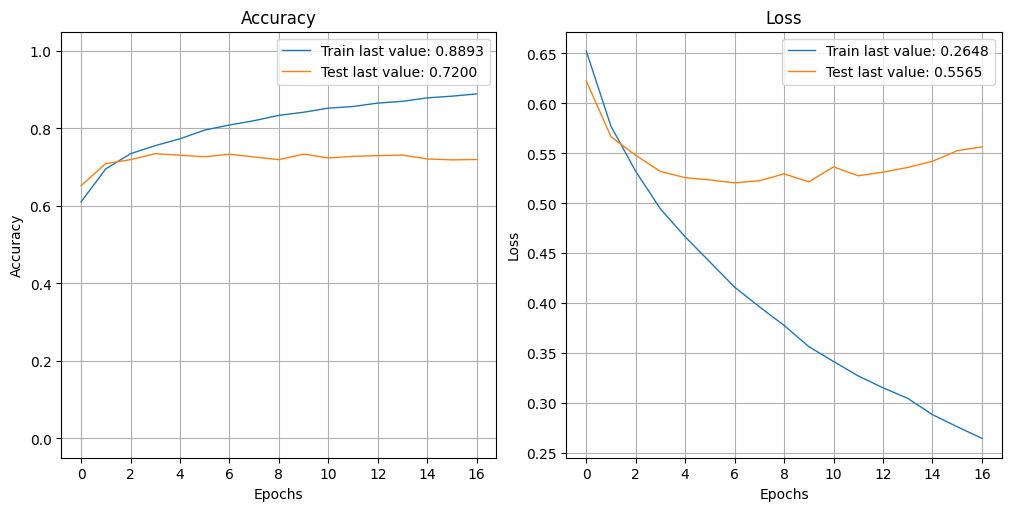

In [68]:
from keras.layers import GlobalMaxPooling1D

embedding_layer = Embedding(input_dim=50000, output_dim=100, trainable=True)
embedding_layer.build((None,))
embedding_layer.set_weights([embedding_matrix])

model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.4))
model.add(GlobalMaxPooling1D())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Appeler la fonction avec votre modèle et nos données
train_evaluate_neural_model('Neurones', 'GloVe', model, X_train_pad, y_train, X_test_pad, y_test, X_val_pad, y_val)

## Réseau de neurones avec GloVe + LSTM

Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.6342 - loss: 0.6270
Epoch 1: val_loss improved from inf to 0.53619, saving model to model_best_weights.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 22s 61ms/step - accuracy: 0.6344 - loss: 0.6268 - val_accuracy: 0.7340 - val_loss: 0.5362
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.7787 - loss: 0.4668
Epoch 2: val_loss improved from 0.53619 to 0.50556, saving model to model_best_weights.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 59ms/step - accuracy: 0.7787 - loss: 0.4667 - val_accuracy: 0.7480 - val_loss: 0.5056
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.8361 - loss: 0.3879
Epoch 3: val_loss did not improve from 0.50556
250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 58ms/step - accuracy: 0.8361 - loss: 0.3878 - val_accuracy: 0.7545 - val_loss: 0.5237
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.8786 - loss: 0.2968
Epoch 4: val_loss did not improve from 0.50556
250/250 ━━━━━━━━━━━

2024/04/17 11:43:46 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


Validation Accuracy :  0.7700


2024/04/17 11:43:52 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\pierr\AppData\Local\Temp\tmp0ykm4mtq\model, flavor: keras). Fall back to return ['keras==3.2.1']. Set logging level to DEBUG to see the full traceback. 


500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step

Test Metrics:
Accuracy: 0.7045000195503235
Recall: 0.748
F1 Score: 0.7479196022718749
AUC: 0.8330188981229917
Specificity: 0.7729124236252546
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step

Validation Metrics:
Accuracy: 0.7699999809265137
Recall: 0.77
F1 Score: 0.7695578540120767
AUC: 0.8469985410026326
Specificity: 0.8061716489874639


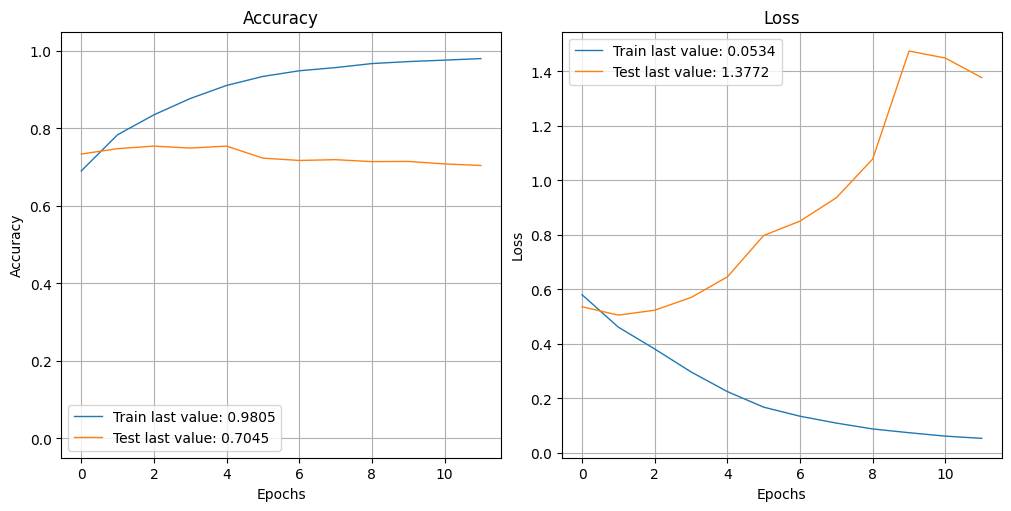

In [69]:
embedding_layer = Embedding(input_dim=50000, output_dim=100, trainable=True)
embedding_layer.build((None,))
embedding_layer.set_weights([embedding_matrix])

model = Sequential()
model.add(embedding_layer)
model.add(Bidirectional(LSTM(128)))
model.add(Dropout(0.4))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


# Appeler la fonction avec votre modèle et nos données
train_evaluate_neural_model('Neurones', 'GloVe_LSTM', model, X_train_pad, y_train, X_test_pad, y_test, X_val_pad, y_val)

## Réseau de neurones avec GloVe + GRU

Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.6353 - loss: 0.6247
Epoch 1: val_loss improved from inf to 0.54639, saving model to model_best_weights.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 18s 65ms/step - accuracy: 0.6355 - loss: 0.6245 - val_accuracy: 0.7305 - val_loss: 0.5464
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.7931 - loss: 0.4613
Epoch 2: val_loss improved from 0.54639 to 0.50949, saving model to model_best_weights.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 16s 64ms/step - accuracy: 0.7931 - loss: 0.4613 - val_accuracy: 0.7575 - val_loss: 0.5095
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8435 - loss: 0.3705
Epoch 3: val_loss did not improve from 0.50949
250/250 ━━━━━━━━━━━━━━━━━━━━ 16s 64ms/step - accuracy: 0.8435 - loss: 0.3705 - val_accuracy: 0.7555 - val_loss: 0.5779
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.8877 - loss: 0.2688
Epoch 4: val_loss did not improve from 0.50949
250/250 ━━━━━━━━━━━

2024/04/17 11:47:23 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


Validation Accuracy :  0.7680


2024/04/17 11:47:30 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\pierr\AppData\Local\Temp\tmpt8zq5lo3\model, flavor: keras). Fall back to return ['keras==3.2.1']. Set logging level to DEBUG to see the full traceback. 


500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step

Test Metrics:
Accuracy: 0.7135000228881836
Recall: 0.7575
F1 Score: 0.7573740516159008
AUC: 0.8330574106010347
Specificity: 0.7871690427698574
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

Validation Metrics:
Accuracy: 0.7680000066757202
Recall: 0.768
F1 Score: 0.7674614410611998
AUC: 0.8514336126156707
Specificity: 0.8081002892960463


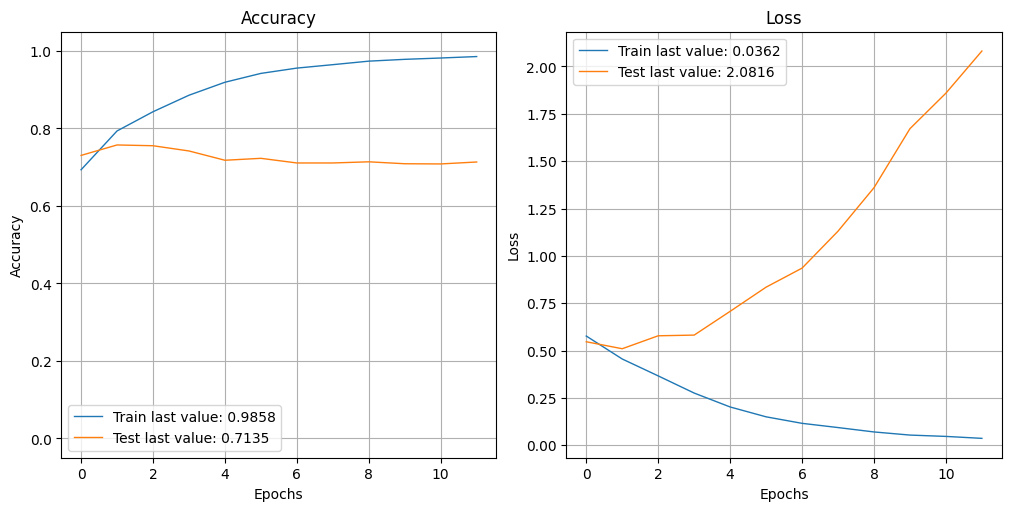

In [70]:
embedding_layer = Embedding(input_dim=50000, output_dim=100, trainable=True)
embedding_layer.build((None,))
embedding_layer.set_weights([embedding_matrix])

model = Sequential()
model.add(embedding_layer)
model.add(Bidirectional(GRU(128)))
model.add(Dropout(0.4))
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


# Appeler la fonction avec votre modèle et nos données
train_evaluate_neural_model('Neurones', 'GloVe_GRU', model, X_train_pad, y_train, X_test_pad, y_test, X_val_pad, y_val)

## Réseau de neurones avec FastText

In [71]:
import fasttext.util

# Charger le modèle FastText
ft = fasttext.load_model('C:/Users/pierr/Projet7/data/FastText/cc.en.300.bin')

# Préparer la matrice d'embedding
embedding_matrix = np.zeros((50000, ft.get_dimension()))  # Assurez-vous que la dimension correspond à celle de votre modèle FastText
for word, i in tokenizer.word_index.items():
    if i < 50000:
        if word in ft:
            embedding_matrix[i] = ft[word]

Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.6656 - loss: 0.5974
Epoch 1: val_loss improved from inf to 0.53219, saving model to model_best_weights.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 43s 165ms/step - accuracy: 0.6659 - loss: 0.5972 - val_accuracy: 0.7440 - val_loss: 0.5322
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.8424 - loss: 0.3786
Epoch 2: val_loss did not improve from 0.53219
250/250 ━━━━━━━━━━━━━━━━━━━━ 40s 160ms/step - accuracy: 0.8424 - loss: 0.3786 - val_accuracy: 0.7445 - val_loss: 0.5506
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.8973 - loss: 0.2576
Epoch 3: val_loss did not improve from 0.53219
250/250 ━━━━━━━━━━━━━━━━━━━━ 40s 160ms/step - accuracy: 0.8973 - loss: 0.2576 - val_accuracy: 0.7395 - val_loss: 0.6109
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.9282 - loss: 0.1747
Epoch 4: val_loss did not improve from 0.53219
250/250 ━━━━━━━━━━━━━━━━━━━━ 40s 160ms/step - accuracy: 0.

2024/04/17 11:57:35 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


Validation Accuracy :  0.7580


2024/04/17 11:57:44 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\pierr\AppData\Local\Temp\tmpzfz30uef\model, flavor: keras). Fall back to return ['keras==3.2.1']. Set logging level to DEBUG to see the full traceback. 


500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step

Test Metrics:
Accuracy: 0.722000002861023
Recall: 0.744
F1 Score: 0.7421103055072026
AUC: 0.8257190329666813
Specificity: 0.6608961303462322
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step

Validation Metrics:
Accuracy: 0.7580000162124634
Recall: 0.758
F1 Score: 0.7572816193430206
AUC: 0.8425975159994031
Specificity: 0.6933461909353905


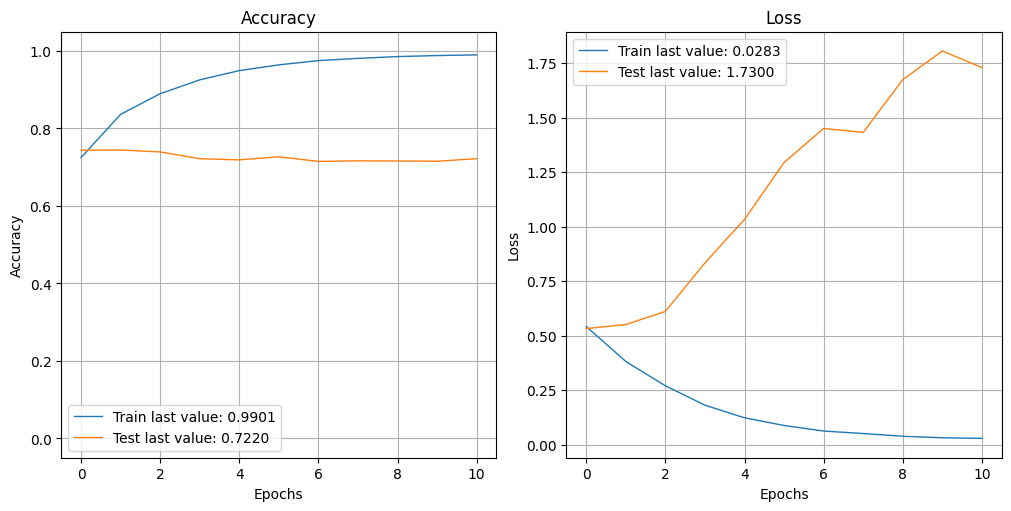

In [72]:
embedding_layer = Embedding(input_dim=50000, output_dim=embedding_matrix.shape[1], trainable=True)
embedding_layer.build((None,))
embedding_layer.set_weights([embedding_matrix])

model = Sequential()
model.add(embedding_layer)
model.add(Bidirectional(LSTM(128)))
model.add(Dropout(0.3))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Appeler la fonction avec votre modèle et nos données
train_evaluate_neural_model('Neurones', 'FastText_LSTM', model, X_train_pad, y_train, X_test_pad, y_test, X_val_pad, y_val)

Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.6638 - loss: 0.5962
Epoch 1: val_loss improved from inf to 0.53699, saving model to model_best_weights.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 47s 180ms/step - accuracy: 0.6640 - loss: 0.5960 - val_accuracy: 0.7290 - val_loss: 0.5370
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.8394 - loss: 0.3810
Epoch 2: val_loss did not improve from 0.53699
250/250 ━━━━━━━━━━━━━━━━━━━━ 43s 173ms/step - accuracy: 0.8394 - loss: 0.3810 - val_accuracy: 0.7405 - val_loss: 0.5463
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.8967 - loss: 0.2613
Epoch 3: val_loss did not improve from 0.53699
250/250 ━━━━━━━━━━━━━━━━━━━━ 43s 172ms/step - accuracy: 0.8967 - loss: 0.2614 - val_accuracy: 0.7345 - val_loss: 0.6819
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.9338 - loss: 0.1626
Epoch 4: val_loss did not improve from 0.53699
250/250 ━━━━━━━━━━━━━━━━━━━━ 42s 168ms/step - accuracy: 0.

2024/04/17 12:05:48 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


Validation Accuracy :  0.7515


2024/04/17 12:05:55 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\pierr\AppData\Local\Temp\tmpmw46nwdp\model, flavor: keras). Fall back to return ['keras==3.2.1']. Set logging level to DEBUG to see the full traceback. 


500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

Test Metrics:
Accuracy: 0.7045000195503235
Recall: 0.729
F1 Score: 0.7266101281760721
AUC: 0.8206053761418699
Specificity: 0.8289205702647657
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

Validation Metrics:
Accuracy: 0.7515000104904175
Recall: 0.7515
F1 Score: 0.7491165947360751
AUC: 0.8359303887021332
Specificity: 0.8379942140790743


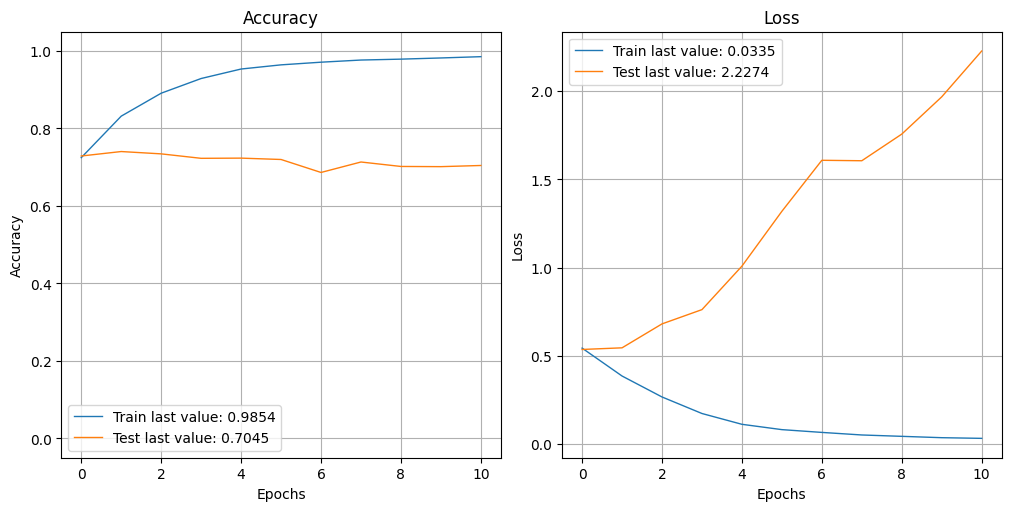

In [73]:
embedding_layer = Embedding(input_dim=50000, output_dim=embedding_matrix.shape[1], trainable=True)
embedding_layer.build((None,))
embedding_layer.set_weights([embedding_matrix])

model = Sequential()
model.add(embedding_layer)
model.add(Bidirectional(GRU(128)))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Appeler la fonction avec votre modèle et nos données
train_evaluate_neural_model('Neurones', 'FastText_GRU', model, X_train_pad, y_train, X_test_pad, y_test, X_val_pad, y_val)

## Modèle Réseau de neurone avec USE

In [56]:
import tensorflow_hub as hub
import tensorflow as tf
use_model = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
X_train_embeddings = use_model(X_train)
X_test_embeddings = use_model(X_test)
X_val_embeddings = use_model(X_val)

Epoch 1/50


C:\Users\pierr\anaconda3\envs\OC7\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


233/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7018 - loss: 0.5868
Epoch 1: val_loss improved from inf to 0.51656, saving model to model_best_weights.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7046 - loss: 0.5829 - val_accuracy: 0.7400 - val_loss: 0.5166
Epoch 2/50
239/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7649 - loss: 0.4853
Epoch 2: val_loss did not improve from 0.51656
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7649 - loss: 0.4852 - val_accuracy: 0.7375 - val_loss: 0.5182
Epoch 3/50
239/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7835 - loss: 0.4633
Epoch 3: val_loss improved from 0.51656 to 0.50840, saving model to model_best_weights.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7833 - loss: 0.4634 - val_accuracy: 0.7485 - val_loss: 0.5084
Epoch 4/50
240/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8006 - loss: 0.4323
Epoch 4: val_loss improved from 0.50840 to 0.50263, saving model to model_best_weights.

2024/04/17 10:35:48 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


Validation Accuracy :  0.7625
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 623us/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 663us/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 660us/step

Test Metrics:
Accuracy: 0.7350000143051147
Recall: 0.745
F1 Score: 0.7449839279122094
AUC: 0.832535741580272
Specificity: 0.7372708757637475
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 675us/step

Validation Metrics:
Accuracy: 0.762499988079071
Recall: 0.7625
F1 Score: 0.7625347711019765
AUC: 0.84092021978088
Specificity: 0.7666345226615237


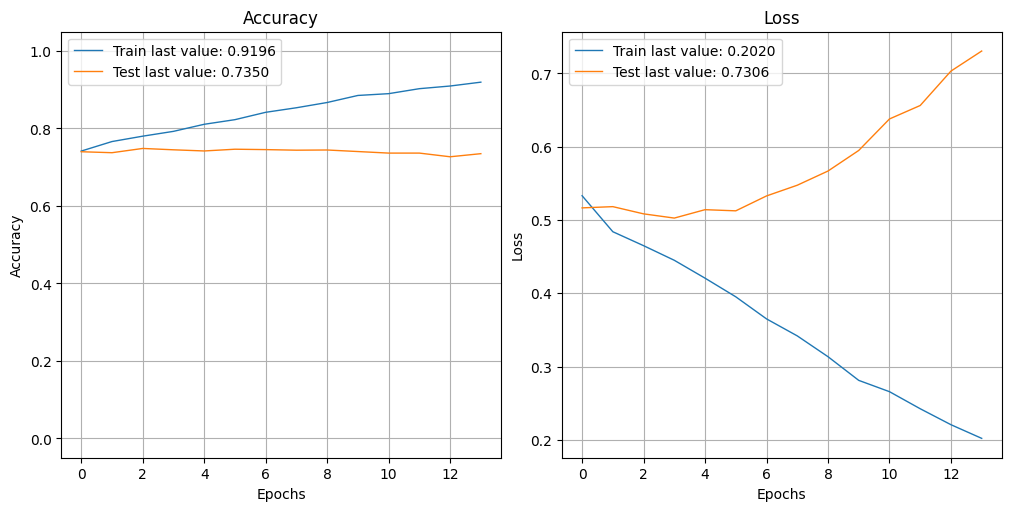

In [57]:
model = Sequential()
model.add(Dense(256, activation='relu', input_shape=(512,)))
model.add(Dropout(0.4))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

train_evaluate_neural_model('Neurones', 'USE', model, X_train_embeddings, y_train, X_test_embeddings, y_test, X_val_embeddings, y_val)

# BERT

In [58]:
# Fonction de préparation des sentences
def bert_inp_fct(sentences, bert_tokenizer, max_length) :
    input_ids=[]
    token_type_ids = []
    attention_mask=[]
    bert_inp_tot = []

    for sent in sentences:
        bert_inp = bert_tokenizer.encode_plus(sent,
                                              add_special_tokens = True,
                                              max_length = max_length,
                                              padding='max_length',
                                              return_attention_mask = True,
                                              return_token_type_ids=True,
                                              truncation=True,
                                              return_tensors="tf")

        input_ids.append(bert_inp['input_ids'][0])
        token_type_ids.append(bert_inp['token_type_ids'][0])
        attention_mask.append(bert_inp['attention_mask'][0])
        bert_inp_tot.append((bert_inp['input_ids'][0],
                             bert_inp['token_type_ids'][0],
                             bert_inp['attention_mask'][0]))

    input_ids = np.asarray(input_ids)
    token_type_ids = np.asarray(token_type_ids)
    attention_mask = np.array(attention_mask)

    return input_ids, token_type_ids, attention_mask, bert_inp_tot


# Fonction de création des features
def feature_BERT_fct(model, model_type, sentences, max_length, b_size, mode='HF') :
    batch_size = b_size
    batch_size_pred = b_size
    bert_tokenizer = AutoTokenizer.from_pretrained(model_type)
    time1 = time.time()

    last_hidden_states_tot = None

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        input_ids, token_type_ids, attention_mask, bert_inp_tot = bert_inp_fct(sentences[idx:idx+batch_size],
                                                                      bert_tokenizer, max_length)

        if mode=='HF' :    # Bert HuggingFace
            outputs = model.predict([input_ids, attention_mask, token_type_ids], batch_size=batch_size_pred)
            last_hidden_states = outputs.last_hidden_state

        if mode=='TFhub' : # Bert Tensorflow Hub
            text_preprocessed = {"input_word_ids" : input_ids,
                                 "input_mask" : attention_mask,
                                 "input_type_ids" : token_type_ids}
            outputs = model(text_preprocessed)
            last_hidden_states = outputs['sequence_output']

        if last_hidden_states_tot is None :
            last_hidden_states_tot = last_hidden_states
        elif last_hidden_states.ndim > 0 and last_hidden_states_tot.ndim > 0:
            last_hidden_states_tot = np.concatenate((last_hidden_states_tot,last_hidden_states))

    if last_hidden_states_tot is not None:
        features_bert = np.array(last_hidden_states_tot).mean(axis=1)
    else:
        features_bert = None

    time2 = np.round(time.time() - time1,0)
    print("temps traitement : ", time2)

    return features_bert, last_hidden_states_tot




In [59]:
from transformers import TFAutoModel, AutoTokenizer
max_length = 64
batch_size = 10
model_type = 'bert-base-uncased'
model = TFAutoModel.from_pretrained(model_type)
sentences = df_model['text_filter_lem'].to_list()

C:\Users\pierr\anaconda3\envs\OC7\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions 

In [60]:
import os, sys, time
# Création des features

features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences,
                                                         max_length, batch_size, mode='HF')

1/1 [==============================] - 0s 339ms/step
temps traitement :  1521.0


In [61]:
def train_evaluate_BERT_model(name_exp, run_name, model, X_train_bert, y_train, X_test_bert, y_test, X_val_bert, y_val):
    # Définir le nom de l'expérience
    mlflow.set_experiment(name_exp)

    # Commencer une nouvelle "run" MLflow
    with mlflow.start_run(run_name=run_name):
        # Enregistrer les paramètres du modèle
        mlflow.log_param("num_layers", len(model.layers))
        mlflow.log_param("optimizer", model.optimizer.get_config()['name'])
        
        # Création du callback
        model_save_path = 'model_best_weights.keras'
        checkpoint = ModelCheckpoint(model_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
        callbacks_list = [checkpoint, es]

        # Entraînement du modèle
        history = model.fit(X_train_bert, y_train, epochs=50, batch_size=64, callbacks=callbacks_list, validation_data=(X_test_bert, y_test), verbose=1)

        # Score du dernier epoch
        loss, accuracy_train = model.evaluate(X_train_bert, y_train, verbose=True)
        print("Training Accuracy: {:.4f}".format(accuracy_train))
        print()
        loss, accuracy_test = model.evaluate(X_test_bert, y_test, verbose=True)
        print("Validation Accuracy:  {:.4f}".format(accuracy_test))

        # Enregistrer les métriques du modèle
        mlflow.log_metric("train_accuracy", accuracy_train)
        mlflow.log_metric("test_accuracy", accuracy_test)

        # Score de l'epoch optimal
        model.load_weights(model_save_path)
        loss, accuracy_val = model.evaluate(X_val_bert, y_val, verbose=False)
        print("Validation Accuracy :  {:.4f}".format(accuracy_val))

        # Enregistrer les métriques du modèle
        mlflow.log_metric("val_accuracy", accuracy_val)

        # Enregistrer le modèle
        mlflow.keras.log_model(model, "model")

        # Prédiction et évaluation du modèle
        y_pred_train = (model.predict(X_train_bert) > 0.5).astype("int32")
        y_pred_test = (model.predict(X_test_bert) > 0.5).astype("int32")
        y_pred_val = (model.predict(X_val_bert) > 0.5).astype("int32")

        # Calcul des métriques pour l'ensemble de test
        y_pred_prob_test = model.predict(X_test_bert)
        recall_test = recall_score(y_test, y_pred_test, average='weighted')
        f1_test = f1_score(y_test, y_pred_test, average='weighted')
        auc_test = roc_auc_score(y_test, y_pred_prob_test)
        tn_test, fp_test, fn_test, tp_test = confusion_matrix(y_test, y_pred_test).ravel()
        specificity_test = tn_test / (tn_test+fp_test)

        print("\nTest Metrics:")
        print(f'Accuracy: {accuracy_test}')
        print(f'Recall: {recall_test}')
        print(f'F1 Score: {f1_test}')
        print(f'AUC: {auc_test}')
        print(f'Specificity: {specificity_test}')

        # Enregistrement des métriques de l'ensemble de test dans MLflow
        mlflow.log_metric("accuracy_test", accuracy_test)
        mlflow.log_metric("recall_test", recall_test)
        mlflow.log_metric("f1_test", f1_test)
        mlflow.log_metric("auc_test", auc_test)
        mlflow.log_metric("specificity_test", specificity_test)

        # Calcul des métriques pour l'ensemble de validation
        y_pred_prob_val = model.predict(X_val_bert)
        recall_val = recall_score(y_val, y_pred_val, average='weighted')
        f1_val = f1_score(y_val, y_pred_val, average='weighted')
        auc_val = roc_auc_score(y_val, y_pred_prob_val)
        tn_val, fp_val, fn_val, tp_val = confusion_matrix(y_val, y_pred_val).ravel()
        specificity_val = tn_val / (tn_val+fp_val)

        print("\nValidation Metrics:")
        print(f'Accuracy: {accuracy_val}')
        print(f'Recall: {recall_val}')
        print(f'F1 Score: {f1_val}')
        print(f'AUC: {auc_val}')
        print(f'Specificity: {specificity_val}')

        # Enregistrement des paramètres et des métriques dans MLflow
        mlflow.log_metric("accuracy_val", accuracy_val)
        mlflow.log_metric("recall_val", recall_val)
        mlflow.log_metric("f1_val", f1_val)
        mlflow.log_metric("auc_val", auc_val)
        mlflow.log_metric("specificity_val", specificity_val)

        show_history(history)
        plot_history(history, path="standard.png")
        plt.close()

# Utilisation des features de BERT
X_train_bert = features_bert[y_train.index]
X_test_bert = features_bert[y_test.index]
X_val_bert = features_bert[y_val.index]


C:\Users\pierr\anaconda3\envs\OC7\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
231/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6606 - loss: 0.5973
Epoch 1: val_loss improved from inf to 0.53962, saving model to model_best_weights.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6645 - loss: 0.5939 - val_accuracy: 0.7370 - val_loss: 0.5396
Epoch 2/50
224/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7455 - loss: 0.5149
Epoch 2: val_loss improved from 0.53962 to 0.53636, saving model to model_best_weights.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7453 - loss: 0.5149 - val_accuracy: 0.7310 - val_loss: 0.5364
Epoch 3/50
244/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7613 - loss: 0.4937
Epoch 3: val_loss improved from 0.53636 to 0.52340, saving model to model_best_weights.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7612 - loss: 0.4938 - val_accuracy: 0.7445 - val_loss: 0.5234
Epoch 4/50
244/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7606 - loss: 0.4895
Epoch 4: val_loss improved fro

2024/04/17 11:01:28 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


Validation Accuracy :  0.7390


2024/04/17 11:01:34 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\pierr\AppData\Local\Temp\tmp10cx_vm5\model, flavor: keras). Fall back to return ['keras==3.2.1']. Set logging level to DEBUG to see the full traceback. 


500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 764us/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 789us/step

Test Metrics:
Accuracy: 0.7279999852180481
Recall: 0.742
F1 Score: 0.7418842975206612
AUC: 0.8214171391530857
Specificity: 0.7230142566191446
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step

Validation Metrics:
Accuracy: 0.7390000224113464
Recall: 0.739
F1 Score: 0.7390266222396001
AUC: 0.8272114524784429
Specificity: 0.7155255544840887


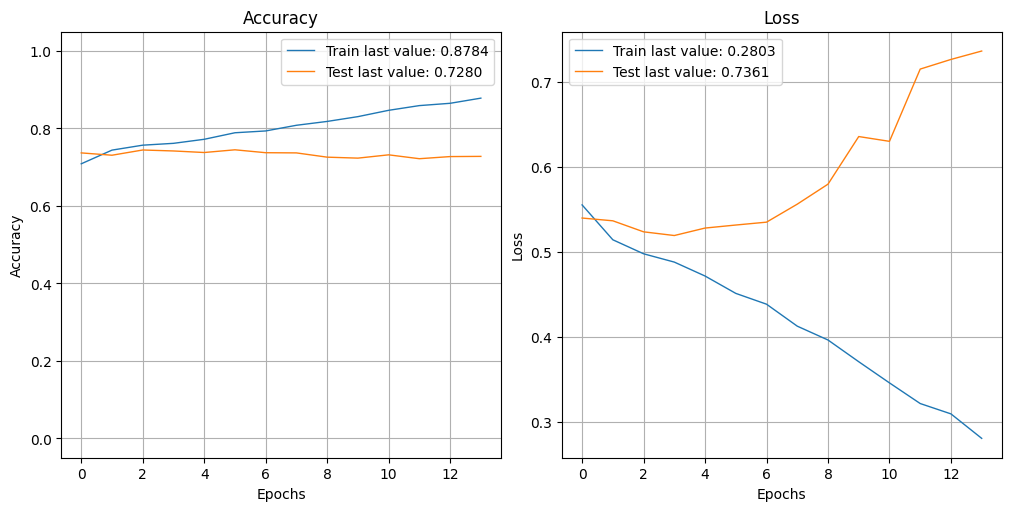

In [62]:
from keras.layers import Reshape

input_dim = X_train_bert.shape[1]
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=input_dim)) 
model.add(Reshape((1, 128)))
model.add(Bidirectional(LSTM(128)))
model.add(Dropout(0.4))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Appeler la fonction avec votre modèle et nos données
train_evaluate_BERT_model('Neurones', 'BERT_LSDM', model, X_train_bert, y_train, X_test_bert, y_test, X_val_bert, y_val)

Epoch 1/50


C:\Users\pierr\anaconda3\envs\OC7\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


228/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6700 - loss: 0.5946
Epoch 1: val_loss improved from inf to 0.53285, saving model to model_best_weights.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6743 - loss: 0.5907 - val_accuracy: 0.7355 - val_loss: 0.5329
Epoch 2/50
231/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7486 - loss: 0.5113
Epoch 2: val_loss improved from 0.53285 to 0.53093, saving model to model_best_weights.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7487 - loss: 0.5113 - val_accuracy: 0.7395 - val_loss: 0.5309
Epoch 3/50
247/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7565 - loss: 0.5010
Epoch 3: val_loss improved from 0.53093 to 0.51443, saving model to model_best_weights.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7565 - loss: 0.5009 - val_accuracy: 0.7470 - val_loss: 0.5144
Epoch 4/50
246/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7635 - loss: 0.4842
Epoch 4: val_loss did not improve from 0.

2024/04/17 11:01:46 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/04/17 11:01:52 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\pierr\AppData\Local\Temp\tmppernpil5\model, flavor: keras). Fall back to return ['keras==3.2.1']. Set logging level to DEBUG to see the full traceback. 


500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 715us/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step

Test Metrics:
Accuracy: 0.7365000247955322
Recall: 0.747
F1 Score: 0.7470164477796748
AUC: 0.8258285684561799
Specificity: 0.7474541751527495
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step

Validation Metrics:
Accuracy: 0.7524999976158142
Recall: 0.7525
F1 Score: 0.7525844852486074
AUC: 0.8283369933438878
Specificity: 0.742526518804243


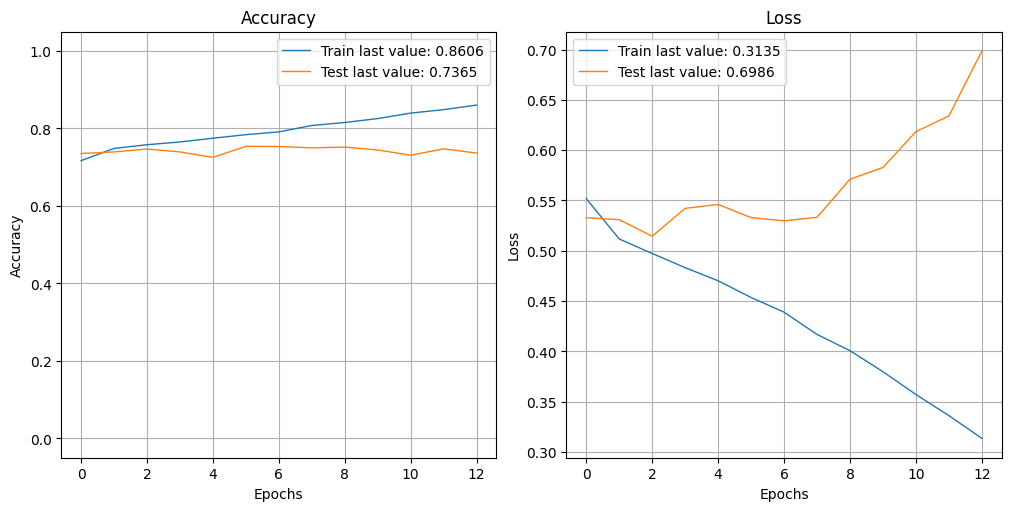

In [63]:
from keras.layers import Reshape

model = Sequential()
model.add(Dense(128, activation='relu', input_dim=input_dim)) 
model.add(Reshape((1, 128)))
model.add(Bidirectional(GRU(128)))
model.add(Dropout(0.4))
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Appeler la fonction avec votre modèle et nos données
train_evaluate_BERT_model('Neurones', 'BERT_GRU', model, X_train_bert, y_train, X_test_bert, y_test, X_val_bert, y_val)

## BERT Model

Le code suivant a été réalisé sur Google Collab pour avoir accès à plus de puissance de calculs.  

In [ ]:
from transformers import *
from transformers import BertTokenizer, TFBertModel, BertConfig
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased',num_labels=2)

In [ ]:
sentences=df_model['text_filter_lem']
labels=df_model['target']
len(sentences),len(labels)

In [ ]:
input_ids=[]
attention_masks=[]

for sent in sentences:
    bert_inp=bert_tokenizer.encode_plus(sent,add_special_tokens = True,max_length =64,pad_to_max_length = True,return_attention_mask = True)
    input_ids.append(bert_inp['input_ids'])
    attention_masks.append(bert_inp['attention_mask'])

input_ids=np.asarray(input_ids)
attention_masks=np.array(attention_masks)
labels=np.array(labels)

In [ ]:
from sklearn.model_selection import train_test_split


train_inp, test_inp, train_label, test_label, train_mask, test_mask = train_test_split(input_ids, labels, attention_masks, test_size=0.2)


train_inp, val_inp, train_label, val_label, train_mask, val_mask = train_test_split(train_inp, train_label, train_mask, test_size=0.25)

In [ ]:
log_dir='tensorboard_data/tb_bert'
model_save_path='./models/bert_model.h5'

callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath=model_save_path,save_weights_only=True,monitor='val_loss',mode='min',save_best_only=True),keras.callbacks.TensorBoard(log_dir=log_dir)]

print('\nBert Model',bert_model.summary())

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5,epsilon=1e-08)

bert_model.compile(loss=loss,optimizer=optimizer,metrics=[metric])

In [ ]:
history=bert_model.fit([train_inp,train_mask],train_label,batch_size=32,epochs=4,validation_data=([val_inp,val_mask],val_label),callbacks=callbacks)

In [ ]:
from sklearn.metrics import confusion_matrix, roc_auc_score

# Prédire les classes pour le jeu de test
y_pred = bert_model.predict([test_inp, test_mask]).logits
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculer la matrice de confusion
cm = confusion_matrix(test_label, y_pred_classes)

# Calculer la spécificité
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn+fp)

# Calculer l'accuracy
accuracy = (tp + tn) / (tp + tn + fp + fn)

# Calculer l'AUC
auc = roc_auc_score(test_label, y_pred[:, 1])

print(f'Test Accuracy: {accuracy}')
print(f'Test Specificity: {specificity}')
print(f'Test AUC: {auc}')

# Modèles retenus avec 100 000 tweets

Les modèles de réseau de neurones qui ont les meilleures résultats vont maintenant être entrainé sur 100 000 tweets.  
La couche "Bidirectionnal" n'étant plus pris en charge par tensorflow 2.16.1, le code ci-dessous est réalisé avec tensorflow==2.15.1.  

In [ ]:
#!pip install tensorflow==2.15.1

In [9]:
df_positifs = df[df['target'] == 0].sample(n=50000, random_state=0)
df_negatifs = df[df['target'] == 1].sample(n=50000, random_state=0)

# Concaténer les deux dataframes
df_model2 = pd.concat([df_positifs, df_negatifs])

# Mélanger les données
df_model2 = df_model2.sample(frac=1, random_state=1).reset_index(drop=True)

In [10]:
df_model2['text_filter_lem'] = df_model2['text'].apply(lambda x : process_text(x,
                                                             rejoin=True,
                                                            lemm_or_stemm="lem",
                                                            force_is_alpha=True,
                                                            include_stopwords=True))

In [11]:
# Séparation des données en ensembles d'entraînement, de test et de validation
X_train, X_temp, y_train, y_temp = train_test_split(df_model2['text_filter_lem'], df_model2['target'], test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
# Préparation des données
tokenizer = Tokenizer(num_words=25000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_val_seq = tokenizer.texts_to_sequences(X_val)
maxlen = max(len(x) for x in X_train_seq)
X_train_pad = pad_sequences(X_train_seq, maxlen=maxlen, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=maxlen, padding='post', truncating='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=maxlen, padding='post', truncating='post')

In [22]:
import fasttext.util

# Charger le modèle FastText
ft = fasttext.load_model('C:/Users/pierr/Projet7/data/FastText/cc.en.300.bin')

# Préparer la matrice d'embedding
embedding_matrix = np.zeros((50000, ft.get_dimension()))
for word, i in tokenizer.word_index.items():
    if i < 50000:
        if word in ft:
            embedding_matrix[i] = ft[word]

In [ ]:
embedding_layer = Embedding(input_dim=50000, output_dim=embedding_matrix.shape[1], trainable=True)
embedding_layer.build((None,))
embedding_layer.set_weights([embedding_matrix])

model = Sequential()
model.add(embedding_layer)
model.add(Bidirectional(GRU(128)))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Appeler la fonction avec votre modèle et nos données
train_evaluate_neural_model('Neurones', 'FastText_GRU100K', model, X_train_pad, y_train, X_test_pad, y_test, X_val_pad, y_val)

Epoch 1/50
1250/1250 [==============================] - ETA: 0s - loss: 0.4890 - accuracy: 0.7639
Epoch 1: val_loss improved from inf to 0.44658, saving model to model_best_weights.keras
1250/1250 [==============================] - 383s 305ms/step - loss: 0.4890 - accuracy: 0.7639 - val_loss: 0.4466 - val_accuracy: 0.7871
Epoch 2/50
1250/1250 [==============================] - ETA: 0s - loss: 0.3946 - accuracy: 0.8209

In [ ]:
import pickle

# Sauvegardez le tokenizer
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Sauvegardez la longueur maximale de séquence
with open('maxlen.pickle', 'wb') as handle:
    pickle.dump(maxlen, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
model.save('FastText_GRU100K.keras', overwrite=True)

In [19]:
# Charger les embeddings de GloVe
embeddings_index = {}
with open('C:/Users/pierr/Projet7/data/GloVe/glove.6B.100d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

# Préparer la matrice d'embedding
embedding_matrix = np.zeros((50000, 100))
for word, i in tokenizer.word_index.items():
    if i < 50000:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

Epoch 1/50
1250/1250 [==============================] - ETA: 0s - loss: 0.5030 - accuracy: 0.7524
Epoch 1: val_loss improved from inf to 0.44856, saving model to model_best_weights.keras
1250/1250 [==============================] - 87s 68ms/step - loss: 0.5030 - accuracy: 0.7524 - val_loss: 0.4486 - val_accuracy: 0.7883
Epoch 2/50
1250/1250 [==============================] - ETA: 0s - loss: 0.4168 - accuracy: 0.8106
Epoch 2: val_loss improved from 0.44856 to 0.44506, saving model to model_best_weights.keras
1250/1250 [==============================] - 83s 66ms/step - loss: 0.4168 - accuracy: 0.8106 - val_loss: 0.4451 - val_accuracy: 0.7963
Epoch 3/50
1250/1250 [==============================] - ETA: 0s - loss: 0.3662 - accuracy: 0.8364
Epoch 3: val_loss did not improve from 0.44506
1250/1250 [==============================] - 84s 67ms/step - loss: 0.3662 - accuracy: 0.8364 - val_loss: 0.4612 - val_accuracy: 0.7917
Epoch 4/50
1250/1250 [==============================] - ETA: 0s - loss: 

2024/04/17 13:31:15 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


Validation Accuracy :  0.7938
INFO:tensorflow:Assets written to: C:\Users\pierr\AppData\Local\Temp\tmp95_bd7_1\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\pierr\AppData\Local\Temp\tmp95_bd7_1\model\data\model\assets


313/313 [==============================] - 4s 13ms/step

Test Metrics:
Accuracy: 0.756600022315979
Recall: 0.7963
F1 Score: 0.7962060042885374
AUC: 0.8761202787050975
Specificity: 0.8193690978501105
313/313 [==============================] - 4s 13ms/step

Validation Metrics:
Accuracy: 0.7937999963760376
Recall: 0.7938
F1 Score: 0.7937251545015473
AUC: 0.8756156586659192
Specificity: 0.8150533306500302


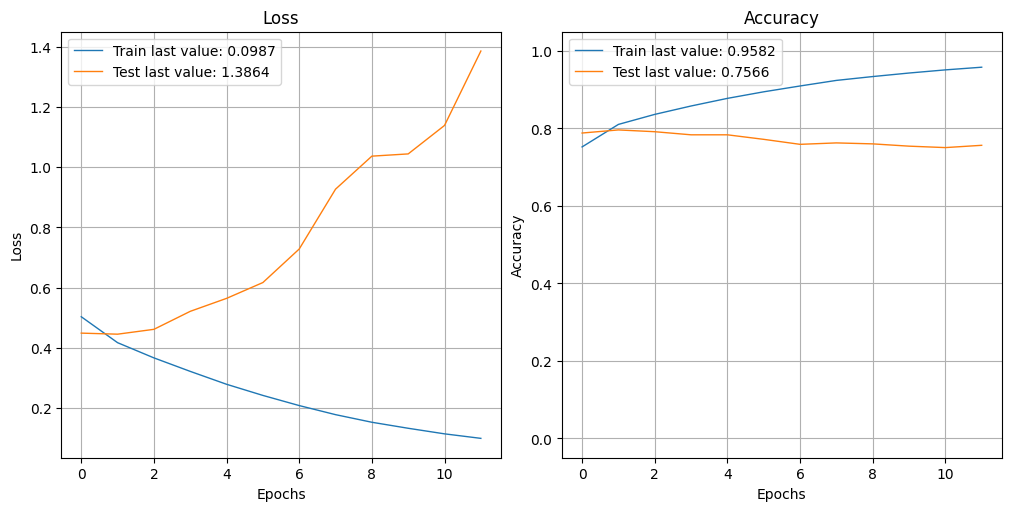

In [20]:
embedding_layer = Embedding(input_dim=50000, output_dim=100, trainable=True)
embedding_layer.build((None,))
embedding_layer.set_weights([embedding_matrix])

model = Sequential()
model.add(embedding_layer)
model.add(Bidirectional(GRU(128)))
model.add(Dropout(0.4))
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


# Appeler la fonction avec votre modèle et nos données
train_evaluate_neural_model('Neurones', 'GloVe_GRU100K', model, X_train_pad, y_train, X_test_pad, y_test, X_val_pad, y_val)

In [21]:
model.save('Gloves_GRU100K.keras', overwrite=True)